# Marie as a firstname over time and departements

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import descartes

from pynsee.download import download_file, get_file_list
from pynsee.geodata import get_geodata_list, get_geodata

In [3]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [4]:
meta = get_file_list()
dfraw = download_file("PRENOM_DEP")

/home/coder/local/bin/conda/envs/basesspcloud/lib/python3.10/site-packages/pynsee/download/_download_store_file.py:72: UserWarning: File in insee.fr modified or corrupted during download
  warnings.warn("File in insee.fr modified or corrupted during download")

Previously saved data has been used:
/home/coder/.cache/pynsee/pynsee/5b82c9d1baeba2127c865b71dbaed396
Set update=True to get the most up-to-date data

Extracting:   0%|          | 0.00/76.3M [00:00<?, ?B/s]

Extracting:  24%|██▍       | 18.2M/76.3M [00:00<00:00, 191MB/s]

Extracting:  50%|█████     | 38.5M/76.3M [00:00<00:00, 203MB/s]

Extracting:  76%|███████▌  | 58.1M/76.3M [00:00<00:00, 204MB/s]

Extracting: 100%|██████████| 76.3M/76.3M [00:00<00:00, 190MB/s]

In [5]:
list_dep = list(dfraw.dpt.unique()) + ['2A', '2B']
list_year = ["1900", "1936", "1965", "2015"]

In [6]:
# compute frequency of marie as a firstname given to female babies
df = dfraw[(dfraw["sexe"] == "2") & (dfraw["annais"].isin(list_year))].reset_index(drop=True)
df["nombre"] = pd.to_numeric(df["nombre"])

df.loc[(df["dpt"] == "78"), 'dpt'] = '75'
df = df.groupby(['dpt', 'annais', 'preusuel'], as_index=False).nombre.agg('sum')
df["tot"] = df.groupby(['dpt', 'annais'], as_index=False).nombre.transform('sum')
marie = df[(df["preusuel"] == "MARIE")].reset_index(drop=True)
marie['pct'] = marie.nombre / marie.tot * 100

In [7]:
# get geographical limits of departements
geodata_list = get_geodata_list()
dep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')
dep = dep.translate()
dep = dep.rename(columns={'insee_dep': 'dpt'})

Previously saved data has been used:
/home/coder/.cache/pynsee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/coder/.cache/pynsee/pynsee/399f6d97ce4631c4e02c487406744440
Set update=True to get the most up-to-date data

In [8]:
DF = pd.concat([pd.DataFrame({'dpt': list_dep, 'annais': y}) for y in list_year])
DF = DF.merge(marie, how = 'left', on = ['dpt', 'annais'])

In [9]:
# data correction
# due to administrative changes in Paris region
# for all years a common value is computed for the following departement : '75', '91', '92', '93', '94', '95', '78'
# departement in Corsica are reported together

for y in list_year:
    valParis = DF.loc[(DF['annais'] == y) & (DF['dpt'] == '75'), 'pct'].values
    valCorse = DF.loc[(DF['annais'] == y) & (DF['dpt'] == '20'), 'pct'].values
    
    for d in ['91', '92', '93', '94', '95', '78']:
        valdep = DF.loc[(DF['annais'] == y) & (DF['dpt'] == d), 'pct'].values
        if np.isnan(valdep):
            DF.loc[(DF['annais'] == y) & (DF['dpt'] == d), 'pct'] = valParis
            
    for d in ['2A', '2B']:
        valdep = DF.loc[(DF['annais'] == y) & (DF['dpt'] == d), 'pct'].values
        if np.isnan(valdep):
            DF.loc[(DF['annais'] == y) & (DF['dpt'] == d), 'pct'] = valCorse

DF['pct'] = DF['pct'].fillna(0)

In [10]:
DF = DF.merge(dep, how = 'left', on = 'dpt')
datamap = gpd.GeoDataFrame(DF)

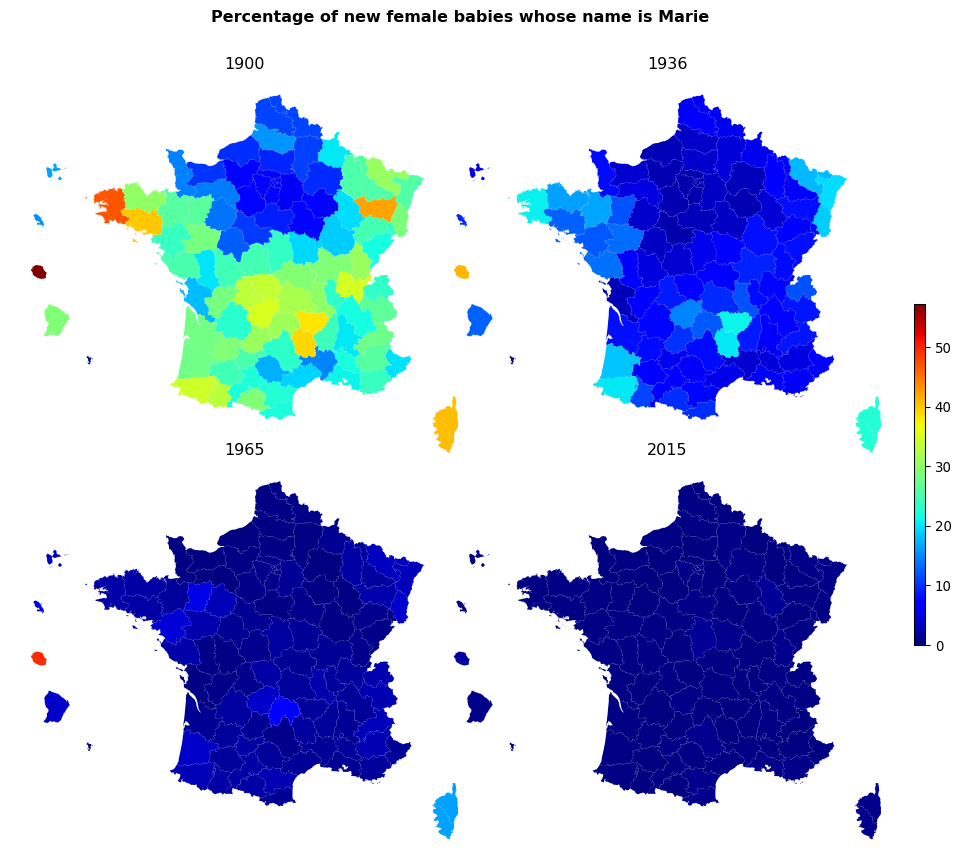

In [11]:
# make plot

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
axes = axes.flatten()

normalize = mcolors.Normalize(vmin=datamap.pct.min(), vmax=datamap.pct.max())
colormap = cm.jet

plt.suptitle("Percentage of new female babies whose name is Marie", x = 0.3, y = 0.9,
             horizontalalignment= 'left',
             fontsize = 12, fontweight='bold')

for a, ax in zip(np.unique(datamap.annais.values), axes):
    
    ax.set_axis_off()
    dt = datamap[datamap.annais == a]
    p = dt.plot(column='pct', ax=ax, cmap=colormap,norm=normalize)
    ax.set_title(a)
    
bbox = ax.get_position() 
cax = fig.add_axes([bbox.x1 + 0.01, bbox.y0 + 0.2, 0.01, bbox.height])
    
fig.colorbar(cm.ScalarMappable(norm=normalize, cmap=colormap), cax=cax)
plt.subplots_adjust(hspace=-0.2, wspace=-0.1)

plt.show()